Importing libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz
from sklearn.metrics import mean_absolute_error
from six import StringIO
from IPython.display import Image  
import pydotplus

SKLearn Decision Tree Regressor implementation for initial understandings and comparison purposes

       Actual  Predicted
44   0.828649   0.867856
69   0.225675   0.214273
161  0.005076   0.007727
35   0.589261   0.596255
182  0.003895   0.002718
11   0.336176   0.354040
122  0.198238   0.207568
81   0.196801   0.185945
110  0.220062   0.207568
180  0.003344   0.002718
172  0.014773   0.021106
127  0.212111   0.207568
29   0.345026   0.354040
16   0.340635   0.334148
108  0.200669   0.207568
67   0.213333   0.195186
28   0.340245   0.354040
51   0.608144   0.596255
31   0.351231   0.354040
155  0.295094   0.297074
47   1.000000   0.867856
4    0.332201   0.334148
97   0.173876   0.180081
187  0.010368   0.002718
56   0.652731   0.642626
106  0.192718   0.207568
152  0.237668   0.244701
82   0.201327   0.195186
53   0.612186   0.596255
130  0.193162   0.195186
66   0.205128   0.195186
119  0.190878   0.189600
58   0.720149   0.642626
84   0.211856   0.214273
186  0.008192   0.002718
14   0.379004   0.354040
40   0.642014   0.642626
19   0.333571   0.334148
164  0.006728   0.007727


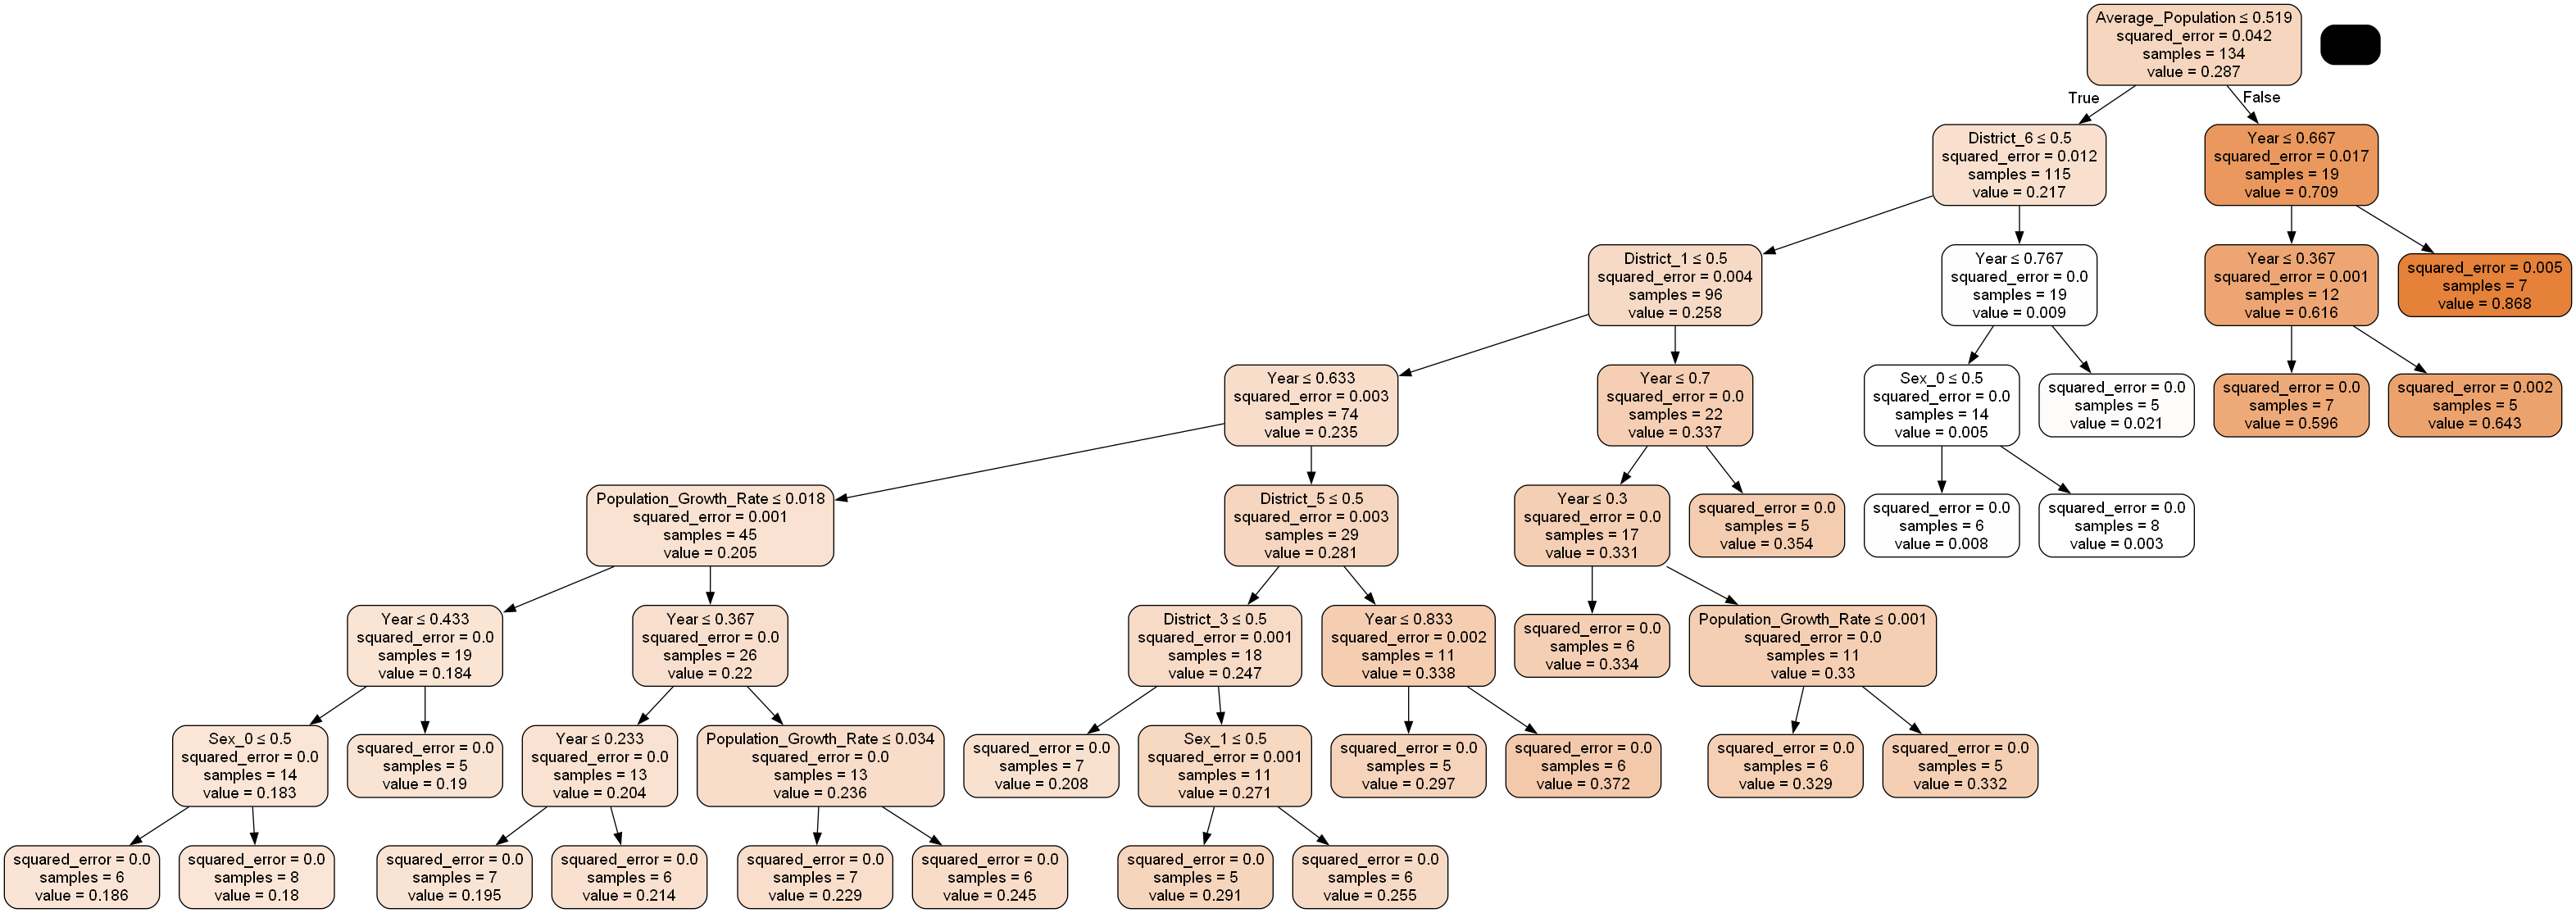

In [2]:
df = pd.read_csv("./NSO_Population_Sex_dataset/NSO_POPULATION_DATA_CLEANED.csv")

feature_cols = ['District', 'Sex', 'Year', 'Population_Growth_Rate','Average_Population']
X = pd.get_dummies(df[feature_cols], columns=['District', 'Sex'])
y = df["Population"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

regressor = DecisionTreeRegressor(max_depth=10, min_samples_split=2, min_samples_leaf=5)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
mae = mean_absolute_error(y_test, y_pred)

print(results_df)
print("Mean Absolute Error:", mae)

dot_data = StringIO()
export_graphviz(regressor, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names=X.columns)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

Decision Trees Implementation (Based on https://github.com/Suji04/ML_from_Scratch/blob/master/decision%20tree%20regression.ipynb)

In [3]:
class Node():
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, var_red=None, value=None):
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.var_red = var_red
        self.value = value

In [4]:
class DecisionTreeRegressor():
    def __init__(self, min_samples_split=2, max_depth=2):
        self.root = None
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth

    def build_tree(self, dataset, curr_depth=0):
        X, Y = dataset[:,:-1], dataset[:,-1]
        num_samples, num_features = np.shape(X)

        best_split = {}

        if num_samples >= self.min_samples_split and curr_depth <= self.max_depth:
            best_split = self.get_best_split(dataset, num_samples, num_features)

            if best_split["var_red"] > 0:
                left_subtree = self.build_tree(best_split["dataset_left"], curr_depth+1)
                right_subtree = self.build_tree(best_split["dataset_right"], curr_depth+1)

                return Node(best_split["feature_index"], best_split["threshold"], left_subtree, right_subtree, best_split["var_red"])
        
        leaf_value = self.calculate_leaf_value(Y)
        return Node(value=leaf_value)
    
    def variance_reduction(self, parent, l_child, r_child):
        weight_l = len(l_child) / len(parent)
        weight_r = len(r_child) / len(parent)

        reduction = np.var(parent) - (weight_l * np.var(l_child) + weight_r * np.var(r_child))
        return reduction
    
    def calculate_leaf_value(self, Y):
        val = np.mean(Y)
        return val
    
    def split(self, dataset, feature_index, threshold):
        dataset_left = np.array([row for row in dataset if row[feature_index] <= threshold])
        dataset_right = np.array([row for row in dataset if row[feature_index] > threshold])
        return dataset_left, dataset_right
    
    def get_best_split(self, dataset, num_samples, num_features):
        best_split = {}
        max_var_red = -float("inf")

        for feature_index in range(num_features):
            feature_values = dataset[:, feature_index]
            possible_thresholds = np.unique(feature_values)

            for threshold in possible_thresholds:
                dataset_left, dataset_right = self.split(dataset, feature_index, threshold)

                if len(dataset_left) > 0 and len(dataset_right) > 0:
                    y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]
                    curr_var_red = self.variance_reduction(y, left_y, right_y)

                    if curr_var_red > max_var_red:
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                        best_split["var_red"] = curr_var_red
                        max_var_red = curr_var_red
                        
        return best_split
    
    def print_tree(self, tree=None, indent=" "):
        if not tree:
            tree = self.root

        if tree.value is not None:
            print(tree.value)
        
        else:
            print("X_"+str(tree.feature_index), "<=", tree.threshold, "?", tree.var_red)
            print("%sleft:" % (indent), end="")
            self.print_tree(tree.left, indent + indent)
            print("%sright:" % (indent), end="")
            self.print_tree(tree.right, indent + indent)

    def fit(self, X, Y):
        dataset = np.column_stack((X.values, Y.values))
        self.root = self.build_tree(dataset)

    def make_prediction(self, x, tree):
        if tree.value != None: return tree.value

        feature_val = x[tree.feature_index]

        if feature_val <= tree.threshold:
            return self.make_prediction(x, tree.left)
        else:
            return self.make_prediction(x, tree.right)
        
    def predict(self, X):
        X_array = X.values
        predictions = [self.make_prediction(x, self.root) for x in X_array]
        return predictions

In [5]:
data = pd.read_csv("./NSO_Population_Sex_dataset/NSO_POPULATION_DATA_CLEANED.csv")
data.head(5)

feature_cols = ['District', 'Sex', 'Year', 'Population_Growth_Rate','Average_Population']
X = pd.get_dummies(data[feature_cols], columns=['District', 'Sex'])
Y = data["Population"]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=41)

regressor = DecisionTreeRegressor(min_samples_split=2, max_depth=100)
regressor.fit(X_train, Y_train)

print("Decision Tree:")
regressor.print_tree()

Y_pred = regressor.predict(X_test)
results_df = pd.DataFrame({'Actual': Y_test, 'Predicted': Y_pred})
mae = np.mean(np.abs(Y_pred - Y_test))

print("\nPopulation Prediction Results:")
print(results_df)

print("\nMean Absolute Error (MAE):", mae)

Decision Tree:
X_2 <= 0.3383667288916345 ? 0.03240134475993159
 left:X_2 <= 0.0096136736009454 ? 0.009772190758303923
  left:X_0 <= 0.8 ? 5.568032563951905e-05
    left:X_0 <= 0.6 ? 5.770873635276939e-06
        left:X_9 <= False ? 2.612034943576293e-06
                left:X_0 <= 0.2 ? 5.581300988046759e-07
                                left:X_1 <= -0.1310344827586206 ? 7.470320917524238e-08
                                                                left:0.005076482991096
                                                                right:X_0 <= 0.1333333333333333 ? 1.7675363209117424e-08
                                                                                                                                left:X_0 <= 0.0 ? 5.21242853819802e-08
                                                                                                                                                                                                                                   